# 第9章: RNN, CNN

## 80. ID番号への変換
***
問題51で構築した学習データ中の単語にユニークなID番号を付与したい．学習データ中で最も頻出する単語に$1$，2番目に頻出する単語に$2$，……といった方法で，学習データ中で2回以上出現する単語にID番号を付与せよ．そして，与えられた単語列に対して，ID番号の列を返す関数を実装せよ．ただし，出現頻度が2回未満の単語のID番号はすべて$0$とせよ．

In [1]:
%load_ext lab_black

In [2]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
!unzip NewsAggregatorDataset.zip

--2021-12-13 08:04:08--  https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29224203 (28M) [application/x-httpd-php]
Saving to: ‘NewsAggregatorDataset.zip’

NewsAggregatorDatas 100%[===================>]  27.87M  1.69MB/s    in 17s     

2021-12-13 08:04:26 (1.60 MB/s) - ‘NewsAggregatorDataset.zip’ saved [29224203/29224203]

Archive:  NewsAggregatorDataset.zip
  inflating: 2pageSessions.csv       
   creating: __MACOSX/
  inflating: __MACOSX/._2pageSessions.csv  
  inflating: newsCorpora.csv         
  inflating: __MACOSX/._newsCorpora.csv  
  inflating: readme.txt              
  inflating: __MACOSX/._readme.txt   


In [3]:
!wc -l ./newsCorpora.csv

422937 ./newsCorpora.csv


In [4]:
!head -10 ./newsCorpora.csv

1	Fed official says weak data caused by weather, should not slow taper	http://www.latimes.com/business/money/la-fi-mo-federal-reserve-plosser-stimulus-economy-20140310,0,1312750.story\?track=rss	Los Angeles Times	b	ddUyU0VZz0BRneMioxUPQVP6sIxvM	www.latimes.com	1394470370698
2	Fed's Charles Plosser sees high bar for change in pace of tapering	http://www.livemint.com/Politics/H2EvwJSK2VE6OF7iK1g3PP/Feds-Charles-Plosser-sees-high-bar-for-change-in-pace-of-ta.html	Livemint	b	ddUyU0VZz0BRneMioxUPQVP6sIxvM	www.livemint.com	1394470371207
3	US open: Stocks fall after Fed official hints at accelerated tapering	http://www.ifamagazine.com/news/us-open-stocks-fall-after-fed-official-hints-at-accelerated-tapering-294436	IFA Magazine	b	ddUyU0VZz0BRneMioxUPQVP6sIxvM	www.ifamagazine.com	1394470371550
4	Fed risks falling 'behind the curve', Charles Plosser says	http://www.ifamagazine.com/news/fed-risks-falling-behind-the-curve-charles-plosser-says-294430	IFA Magazine	b	ddUyU0VZz0BRneMioxUPQVP6sIxvM	www

In [5]:
# 読込時のエラー回避のためダブルクォーテーションをシングルクォーテーションに置換
!sed -e 's/"/'\''/g' ./newsCorpora.csv > ./newsCorpora_re.csv

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split

# データの読込
df = pd.read_csv(
    "./newsCorpora_re.csv",
    header=None,
    sep="\t",
    names=[
        "ID",
        "TITLE",
        "URL",
        "PUBLISHER",
        "CATEGORY",
        "STORY",
        "HOSTNAME",
        "TIMESTAMP",
    ],
)

# データの抽出
df = df.loc[
    df["PUBLISHER"].isin(
        ["Reuters", "Huffington Post", "Businessweek", "Contactmusic.com", "Daily Mail"]
    ),
    ["TITLE", "CATEGORY"],
]

# データの分割
train, valid_test = train_test_split(
    df, test_size=0.2, shuffle=True, random_state=123, stratify=df["CATEGORY"]
)
valid, test = train_test_split(
    valid_test,
    test_size=0.5,
    shuffle=True,
    random_state=123,
    stratify=valid_test["CATEGORY"],
)
train.reset_index(drop=True, inplace=True)
valid.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

# 事例数の確認
print("【学習データ】")
print(train["CATEGORY"].value_counts())
print("【検証データ】")
print(valid["CATEGORY"].value_counts())
print("【評価データ】")
print(test["CATEGORY"].value_counts())

【学習データ】
b    4501
e    4235
t    1220
m     728
Name: CATEGORY, dtype: int64
【検証データ】
b    563
e    529
t    153
m     91
Name: CATEGORY, dtype: int64
【評価データ】
b    563
e    530
t    152
m     91
Name: CATEGORY, dtype: int64


In [7]:
from collections import defaultdict
import string

# 単語の頻度集計
d = defaultdict(int)
table = str.maketrans(
    string.punctuation, " " * len(string.punctuation)
)  # 記号をスペースに置換するテーブル
for text in train["TITLE"]:
    for word in text.translate(table).split():
        d[word] += 1
d = sorted(d.items(), key=lambda x: x[1], reverse=True)

# 単語ID辞書の作成
word2id = {word: i + 1 for i, (word, cnt) in enumerate(d) if cnt > 1}  # 出現頻度が2回以上の単語を登録

print(f"ID数: {len(set(word2id.values()))}\n")
print("---頻度上位20語---")
for key in list(word2id)[:20]:
    print(f"{key}: {word2id[key]}")

ID数: 9405

---頻度上位20語---
to: 1
s: 2
in: 3
on: 4
UPDATE: 5
as: 6
US: 7
for: 8
The: 9
of: 10
1: 11
To: 12
2: 13
the: 14
and: 15
In: 16
Of: 17
a: 18
at: 19
A: 20


In [8]:
import torch


def tokenizer(text, word2id=word2id, unk=0):
    """入力テキストをスペースで分割しID列に変換(辞書になければunkで指定した数字を設定)"""
    table = str.maketrans(string.punctuation, " " * len(string.punctuation))
    return [word2id.get(word, unk) for word in text.translate(table).split()]

In [9]:
# 確認
text = train.iloc[1, train.columns.get_loc("TITLE")]
print(f"テキスト: {text}")
print(f"ID列: {tokenizer(text)}")

テキスト: Amazon Plans to Fight FTC Over Mobile-App Purchases
ID列: [169, 539, 1, 683, 1237, 82, 279, 1898, 4199]


## 81. RNNによる予測
***
ID番号で表現された単語列$\boldsymbol{x} = (x_1, x_2, \dots, x_T)$がある．ただし，$T$は単語列の長さ，$x_t \in \mathbb{R}^{V}$は単語のID番号のone-hot表記である（$V$は単語の総数である）．再帰型ニューラルネットワーク（RNN: Recurrent Neural Network）を用い，単語列$\boldsymbol{x}$からカテゴリ$y$を予測するモデルとして，次式を実装せよ．

$
\overrightarrow h_0 = 0, \\
\overrightarrow h_t = {\rm \overrightarrow{RNN}}(\mathrm{emb}(x_t), \overrightarrow h_{t-1}), \\
y = {\rm softmax}(W^{(yh)} \overrightarrow h_T + b^{(y)})
$

ただし，$\mathrm{emb}(x) \in \mathbb{R}^{d_w}$は単語埋め込み（単語のone-hot表記から単語ベクトルに変換する関数），$\overrightarrow h_t \in \mathbb{R}^{d_h}$は時刻$t$の隠れ状態ベクトル，${\rm \overrightarrow{RNN}}(x,h)$は入力$x$と前時刻の隠れ状態$h$から次状態を計算するRNNユニット，$W^{(yh)} \in \mathbb{R}^{L \times d_h}$は隠れ状態ベクトルからカテゴリを予測するための行列，$b^{(y)} \in \mathbb{R}^{L}$はバイアス項である（$d_w, d_h, L$はそれぞれ，単語埋め込みの次元数，隠れ状態ベクトルの次元数，ラベル数である）．RNNユニット${\rm \overrightarrow{RNN}}(x,h)$には様々な構成が考えられるが，典型例として次式が挙げられる．

$
{\rm \overrightarrow{RNN}}(x,h) = g(W^{(hx)} x + W^{(hh)}h + b^{(h)})
$

ただし，$W^{(hx)} \in \mathbb{R}^{d_h \times d_w}，W^{(hh)} \in \mathbb{R}^{d_h \times d_h}, b^{(h)} \in \mathbb{R}^{d_h}$はRNNユニットのパラメータ，$g$は活性化関数（例えば$\tanh$やReLUなど）である．

なお，この問題ではパラメータの学習を行わず，ランダムに初期化されたパラメータで$y$を計算するだけでよい．次元数などのハイパーパラメータは，$d_w = 300, d_h=50$など，適当な値に設定せよ（以降の問題でも同様である）．

In [10]:
import torch
from torch import nn


class RNN(nn.Module):
    def __init__(self, vocab_size, emb_size, padding_idx, output_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=padding_idx)
        self.rnn = nn.RNN(emb_size, hidden_size, nonlinearity="tanh", batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        self.batch_size = x.size()[0]
        hidden = self.init_hidden()  # h0のゼロベクトルを作成
        emb = self.emb(x)
        # emb.size() = (batch_size, seq_len, emb_size)
        out, hidden = self.rnn(emb, hidden)
        # out.size() = (batch_size, seq_len, hidden_size)
        out = self.fc(out[:, -1, :])
        # out.size() = (batch_size, output_size)
        return out

    def init_hidden(self):
        hidden = torch.zeros(1, self.batch_size, self.hidden_size)
        return hidden

In [11]:
from torch.utils.data import Dataset


class CreateDataset(Dataset):
    def __init__(self, X, y, tokenizer):
        self.X = X
        self.y = y
        self.tokenizer = tokenizer

    def __len__(self):  # len(Dataset)で返す値を指定
        return len(self.y)

    def __getitem__(self, index):  # Dataset[index]で返す値を指定
        text = self.X[index]
        inputs = self.tokenizer(text)

        return {
            "inputs": torch.tensor(inputs, dtype=torch.int64),
            "labels": torch.tensor(self.y[index], dtype=torch.int64),
        }

In [12]:
# ラベルベクトルの作成
category_dict = {"b": 0, "t": 1, "e": 2, "m": 3}
y_train = train["CATEGORY"].map(lambda x: category_dict[x]).values
y_valid = valid["CATEGORY"].map(lambda x: category_dict[x]).values
y_test = test["CATEGORY"].map(lambda x: category_dict[x]).values

# Datasetの作成
dataset_train = CreateDataset(train["TITLE"], y_train, tokenizer)
dataset_valid = CreateDataset(valid["TITLE"], y_valid, tokenizer)
dataset_test = CreateDataset(test["TITLE"], y_test, tokenizer)

print(f"len(Dataset)の出力: {len(dataset_train)}")
print("Dataset[index]の出力:")
for var in dataset_train[1]:
    print(f"  {var}: {dataset_train[1][var]}")

len(Dataset)の出力: 10684
Dataset[index]の出力:
  inputs: tensor([ 169,  539,    1,  683, 1237,   82,  279, 1898, 4199])
  labels: 1


In [13]:
# パラメータの設定
VOCAB_SIZE = len(set(word2id.values())) + 1  # 辞書のID数 + パディングID
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50

# モデルの定義
model = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, HIDDEN_SIZE)

# 先頭10件の予測値取得
for i in range(10):
    X = dataset_train[i]["inputs"]
    print(torch.softmax(model(X.unsqueeze(0)), dim=-1))

tensor([[0.2943, 0.2483, 0.2929, 0.1644]], grad_fn=<SoftmaxBackward0>)
tensor([[0.3062, 0.1617, 0.2641, 0.2680]], grad_fn=<SoftmaxBackward0>)
tensor([[0.1730, 0.3827, 0.2816, 0.1627]], grad_fn=<SoftmaxBackward0>)
tensor([[0.1866, 0.2277, 0.3501, 0.2356]], grad_fn=<SoftmaxBackward0>)
tensor([[0.1732, 0.2317, 0.2947, 0.3005]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2764, 0.2840, 0.2510, 0.1886]], grad_fn=<SoftmaxBackward0>)
tensor([[0.4705, 0.1837, 0.1945, 0.1513]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2916, 0.2341, 0.2349, 0.2394]], grad_fn=<SoftmaxBackward0>)
tensor([[0.1116, 0.2457, 0.3938, 0.2489]], grad_fn=<SoftmaxBackward0>)
tensor([[0.1811, 0.1562, 0.1508, 0.5120]], grad_fn=<SoftmaxBackward0>)


## 82. 確率的勾配降下法による学習
***
確率的勾配降下法（SGD: Stochastic Gradient Descent）を用いて，問題81で構築したモデルを学習せよ．訓練データ上の損失と正解率，評価データ上の損失と正解率を表示しながらモデルを学習し，適当な基準（例えば10エポックなど）で終了させよ．

In [14]:
from torch.utils.data import DataLoader
import time
from torch import optim


def calculate_loss_and_accuracy(model, dataset, device=None, criterion=None):
    """損失・正解率を計算"""
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
    loss = 0.0
    total = 0
    correct = 0
    with torch.no_grad():
        for data in dataloader:
            # デバイスの指定
            inputs = data["inputs"].to(device)
            labels = data["labels"].to(device)

            # 順伝播
            outputs = model(inputs)

            # 損失計算
            if criterion != None:
                loss += criterion(outputs, labels).item()

            # 正解率計算
            pred = torch.argmax(outputs, dim=-1)
            total += len(inputs)
            correct += (pred == labels).sum().item()

    return loss / len(dataset), correct / total


def train_model(
    dataset_train,
    dataset_valid,
    batch_size,
    model,
    criterion,
    optimizer,
    num_epochs,
    collate_fn=None,
    device=None,
):
    """モデルの学習を実行し、損失・正解率のログを返す"""
    # デバイスの指定
    model.to(device)

    # dataloaderの作成
    dataloader_train = DataLoader(
        dataset_train, batch_size=batch_size, shuffle=True, collate_fn=collate_fn
    )
    dataloader_valid = DataLoader(dataset_valid, batch_size=1, shuffle=False)

    # スケジューラの設定
    scheduler = optim.lr_scheduler.CosineAnnealingLR(
        optimizer, num_epochs, eta_min=1e-5, last_epoch=-1
    )

    # 学習
    log_train = []
    log_valid = []
    for epoch in range(num_epochs):
        # 開始時刻の記録
        s_time = time.time()

        # 訓練モードに設定
        model.train()
        for data in dataloader_train:
            # 勾配をゼロで初期化
            optimizer.zero_grad()

            # 順伝播 + 誤差逆伝播 + 重み更新
            inputs = data["inputs"].to(device)
            labels = data["labels"].to(device)
            outputs = model.forward(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # 評価モードに設定
        model.eval()

        # 損失と正解率の算出
        loss_train, acc_train = calculate_loss_and_accuracy(
            model, dataset_train, device, criterion=criterion
        )
        loss_valid, acc_valid = calculate_loss_and_accuracy(
            model, dataset_valid, device, criterion=criterion
        )
        log_train.append([loss_train, acc_train])
        log_valid.append([loss_valid, acc_valid])

        # チェックポイントの保存
        torch.save(
            {
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
            },
            f"checkpoint{epoch + 1}.pt",
        )

        # 終了時刻の記録
        e_time = time.time()

        # ログを出力
        print(
            f"epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}, {(e_time - s_time):.4f}sec"
        )

        # 検証データの損失が3エポック連続で低下しなかった場合は学習終了
        if (
            epoch > 2
            and log_valid[epoch - 3][0]
            <= log_valid[epoch - 2][0]
            <= log_valid[epoch - 1][0]
            <= log_valid[epoch][0]
        ):
            break

        # スケジューラを1ステップ進める
        scheduler.step()

    return {"train": log_train, "valid": log_valid}

In [15]:
def visualize_logs(log):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].plot(np.array(log["train"]).T[0], label="train")
    ax[0].plot(np.array(log["valid"]).T[0], label="valid")
    ax[0].set_xlabel("epoch")
    ax[0].set_ylabel("loss")
    ax[0].legend()
    ax[1].plot(np.array(log["train"]).T[1], label="train")
    ax[1].plot(np.array(log["valid"]).T[1], label="valid")
    ax[1].set_xlabel("epoch")
    ax[1].set_ylabel("accuracy")
    ax[1].legend()
    plt.show()

In [16]:
# パラメータの設定
VOCAB_SIZE = len(set(word2id.values())) + 1  # 辞書のID数 + パディングID
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50
LEARNING_RATE = 1e-3
BATCH_SIZE = 1
NUM_EPOCHS = 10

# モデルの定義
model = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, HIDDEN_SIZE)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

# モデルの学習
log = train_model(
    dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS
)

epoch: 1, loss_train: 1.1157, accuracy_train: 0.5135, loss_valid: 1.1435, accuracy_valid: 0.4843, 82.2366sec
epoch: 2, loss_train: 1.0408, accuracy_train: 0.5692, loss_valid: 1.1063, accuracy_valid: 0.5262, 81.5272sec
epoch: 3, loss_train: 0.9128, accuracy_train: 0.6569, loss_valid: 1.0128, accuracy_valid: 0.6085, 81.9107sec
epoch: 4, loss_train: 0.7489, accuracy_train: 0.7374, loss_valid: 0.8805, accuracy_valid: 0.6939, 82.1545sec
epoch: 5, loss_train: 0.6510, accuracy_train: 0.7726, loss_valid: 0.7842, accuracy_valid: 0.7268, 89.0484sec
epoch: 6, loss_train: 0.5786, accuracy_train: 0.7922, loss_valid: 0.7382, accuracy_valid: 0.7463, 82.0808sec
epoch: 7, loss_train: 0.5294, accuracy_train: 0.8105, loss_valid: 0.7140, accuracy_valid: 0.7530, 81.8364sec
epoch: 8, loss_train: 0.4947, accuracy_train: 0.8213, loss_valid: 0.6923, accuracy_valid: 0.7612, 81.9059sec
epoch: 9, loss_train: 0.4804, accuracy_train: 0.8254, loss_valid: 0.6897, accuracy_valid: 0.7597, 80.9005sec
epoch: 10, loss_tra

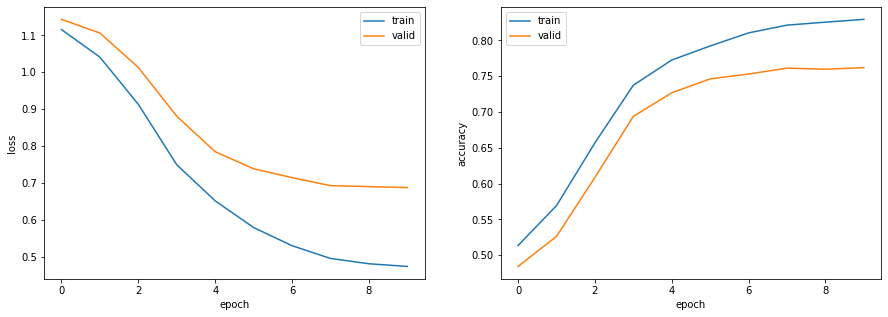

正解率（学習データ）：0.829
正解率（評価データ）：0.784


In [17]:
import numpy as np
from matplotlib import pyplot as plt

# ログの可視化
visualize_logs(log)

# 正解率の算出
_, acc_train = calculate_loss_and_accuracy(model, dataset_train)
_, acc_test = calculate_loss_and_accuracy(model, dataset_test)
print(f"正解率（学習データ）：{acc_train:.3f}")
print(f"正解率（評価データ）：{acc_test:.3f}")

## 83. ミニバッチ化・GPU上での学習
***
問題82のコードを改変し，$B$事例ごとに損失・勾配を計算して学習を行えるようにせよ（$B$の値は適当に選べ）．また，GPU上で学習を実行せよ．

In [18]:
class Padsequence:
    """Dataloaderからミニバッチを取り出すごとに最大系列長でパディング"""

    def __init__(self, padding_idx):
        self.padding_idx = padding_idx

    def __call__(self, batch):
        sorted_batch = sorted(batch, key=lambda x: x["inputs"].shape[0], reverse=True)
        sequences = [x["inputs"] for x in sorted_batch]
        sequences_padded = torch.nn.utils.rnn.pad_sequence(
            sequences, batch_first=True, padding_value=self.padding_idx
        )
        labels = torch.LongTensor([x["labels"] for x in sorted_batch])

        return {"inputs": sequences_padded, "labels": labels}

In [19]:
# パラメータの設定
VOCAB_SIZE = len(set(word2id.values())) + 1  # 辞書のID数 + パディングID
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50
LEARNING_RATE = 5e-2
BATCH_SIZE = 32
NUM_EPOCHS = 10

# モデルの定義
model = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, HIDDEN_SIZE)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

# デバイスの指定
device = torch.device("cpu")

# モデルの学習
log = train_model(
    dataset_train,
    dataset_valid,
    BATCH_SIZE,
    model,
    criterion,
    optimizer,
    NUM_EPOCHS,
    collate_fn=Padsequence(PADDING_IDX),
    device=device,
)

epoch: 1, loss_train: 1.2739, accuracy_train: 0.4054, loss_valid: 1.2892, accuracy_valid: 0.3975, 10.2160sec
epoch: 2, loss_train: 1.1627, accuracy_train: 0.5055, loss_valid: 1.1728, accuracy_valid: 0.4843, 10.2643sec
epoch: 3, loss_train: 1.1027, accuracy_train: 0.5843, loss_valid: 1.1497, accuracy_valid: 0.5674, 10.3016sec
epoch: 4, loss_train: 1.1592, accuracy_train: 0.4973, loss_valid: 1.1746, accuracy_valid: 0.4805, 10.1225sec
epoch: 5, loss_train: 1.2559, accuracy_train: 0.4370, loss_valid: 1.2829, accuracy_valid: 0.4222, 10.1053sec
epoch: 6, loss_train: 1.2024, accuracy_train: 0.4782, loss_valid: 1.2508, accuracy_valid: 0.4633, 10.0900sec
epoch: 7, loss_train: 1.1436, accuracy_train: 0.5234, loss_valid: 1.1953, accuracy_valid: 0.5097, 10.4280sec
epoch: 8, loss_train: 1.1304, accuracy_train: 0.5346, loss_valid: 1.1816, accuracy_valid: 0.5172, 10.1155sec
epoch: 9, loss_train: 1.0888, accuracy_train: 0.5725, loss_valid: 1.1458, accuracy_valid: 0.5472, 10.0014sec
epoch: 10, loss_tra

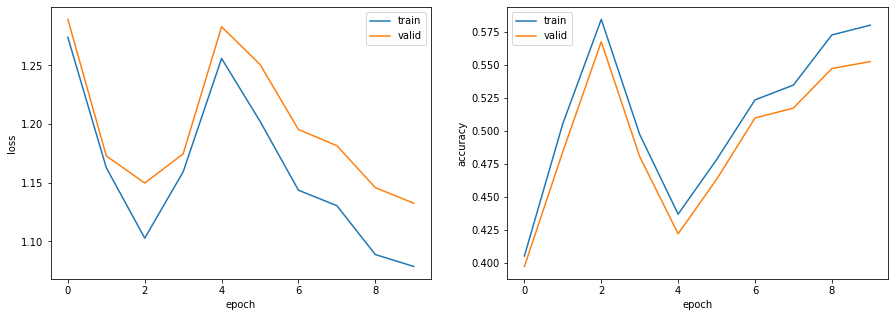

正解率（学習データ）：0.580
正解率（評価データ）：0.559


In [20]:
# ログの可視化
visualize_logs(log)

# 正解率の算出
_, acc_train = calculate_loss_and_accuracy(model, dataset_train, device)
_, acc_test = calculate_loss_and_accuracy(model, dataset_test, device)
print(f"正解率（学習データ）：{acc_train:.3f}")
print(f"正解率（評価データ）：{acc_test:.3f}")

## 84. 単語ベクトルの導入
***
事前学習済みの単語ベクトル（例えば，Google Newsデータセット（約1,000億単語）での学習済み単語ベクトル）で単語埋め込み$emb(x)$を初期化し，学習せよ．

In [21]:
# FILE_ID = "0B7XkCwpI5KDYNlNUTTlSS21pQmM"
# FILE_NAME = "GoogleNews-vectors-negative300.bin.gz"
# !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=$FILE_ID' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=$FILE_ID" -O $FILE_NAME && rm -rf /tmp/cookies.txt

# 下記からダウンロードできます。
# https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz

In [22]:
from gensim.models import KeyedVectors

# 学習済みモデルのロード
model = KeyedVectors.load_word2vec_format(
    "./GoogleNews-vectors-negative300.bin.gz", binary=True
)

# 学習済み単語ベクトルの取得
VOCAB_SIZE = len(set(word2id.values())) + 1
EMB_SIZE = 300
weights = np.zeros((VOCAB_SIZE, EMB_SIZE))
words_in_pretrained = 0
for i, word in enumerate(word2id.keys()):
    try:
        weights[i] = model[word]
        words_in_pretrained += 1
    except KeyError:
        weights[i] = np.random.normal(scale=0.4, size=(EMB_SIZE,))
weights = torch.from_numpy(weights.astype((np.float32)))

print(f"学習済みベクトル利用単語数: {words_in_pretrained} / {VOCAB_SIZE}")
print(weights.size())

学習済みベクトル利用単語数: 9174 / 9406
torch.Size([9406, 300])


In [23]:
class RNN(nn.Module):
    def __init__(
        self,
        vocab_size,
        emb_size,
        padding_idx,
        output_size,
        hidden_size,
        num_layers,
        emb_weights=None,
        bidirectional=False,
    ):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_directions = bidirectional + 1  # 単方向：1、双方向：2
        if emb_weights != None:  # 指定があれば埋め込み層の重みをemb_weightsで初期化
            self.emb = nn.Embedding.from_pretrained(
                emb_weights, padding_idx=padding_idx
            )
        else:
            self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=padding_idx)
        self.rnn = nn.RNN(
            emb_size,
            hidden_size,
            num_layers,
            nonlinearity="tanh",
            bidirectional=bidirectional,
            batch_first=True,
        )
        self.fc = nn.Linear(hidden_size * self.num_directions, output_size)

    def forward(self, x):
        self.batch_size = x.size()[0]
        hidden = self.init_hidden()  # h0のゼロベクトルを作成
        emb = self.emb(x)
        # emb.size() = (batch_size, seq_len, emb_size)
        out, hidden = self.rnn(emb, hidden)
        # out.size() = (batch_size, seq_len, hidden_size * num_directions)
        out = self.fc(out[:, -1, :])
        # out.size() = (batch_size, output_size)
        return out

    def init_hidden(self):
        hidden = torch.zeros(
            self.num_layers * self.num_directions, self.batch_size, self.hidden_size
        )
        return hidden

In [24]:
# パラメータの設定
VOCAB_SIZE = len(set(word2id.values())) + 1  # 辞書のID数 + パディングID
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50
NUM_LAYERS = 1
LEARNING_RATE = 5e-2
BATCH_SIZE = 32
NUM_EPOCHS = 10

# モデルの定義
model = RNN(
    VOCAB_SIZE,
    EMB_SIZE,
    PADDING_IDX,
    OUTPUT_SIZE,
    HIDDEN_SIZE,
    NUM_LAYERS,
    emb_weights=weights,
)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

# デバイスの指定
device = torch.device("cpu")

# モデルの学習
log = train_model(
    dataset_train,
    dataset_valid,
    BATCH_SIZE,
    model,
    criterion,
    optimizer,
    NUM_EPOCHS,
    collate_fn=Padsequence(PADDING_IDX),
    device=device,
)

epoch: 1, loss_train: 1.1663, accuracy_train: 0.4054, loss_valid: 1.1752, accuracy_valid: 0.4064, 7.8087sec
epoch: 2, loss_train: 1.1608, accuracy_train: 0.4341, loss_valid: 1.1735, accuracy_valid: 0.4409, 8.4484sec
epoch: 3, loss_train: 1.0543, accuracy_train: 0.5972, loss_valid: 1.0618, accuracy_valid: 0.5876, 8.8104sec
epoch: 4, loss_train: 1.0026, accuracy_train: 0.6326, loss_valid: 1.0331, accuracy_valid: 0.6190, 8.1953sec
epoch: 5, loss_train: 0.9865, accuracy_train: 0.6346, loss_valid: 0.9924, accuracy_valid: 0.6362, 7.9397sec
epoch: 6, loss_train: 0.9587, accuracy_train: 0.6529, loss_valid: 0.9938, accuracy_valid: 0.6347, 7.9915sec
epoch: 7, loss_train: 0.9314, accuracy_train: 0.6667, loss_valid: 0.9583, accuracy_valid: 0.6504, 7.7991sec
epoch: 8, loss_train: 0.9163, accuracy_train: 0.6694, loss_valid: 0.9412, accuracy_valid: 0.6557, 7.7842sec
epoch: 9, loss_train: 0.9253, accuracy_train: 0.6600, loss_valid: 0.9510, accuracy_valid: 0.6460, 7.9975sec
epoch: 10, loss_train: 0.915

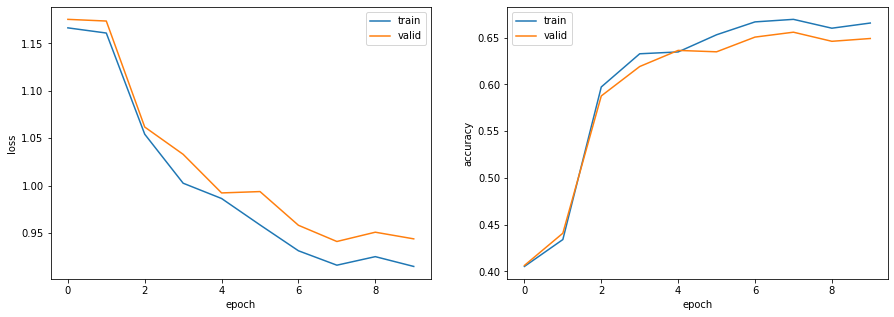

正解率（学習データ）：0.665
正解率（評価データ）：0.653


In [25]:
# ログの可視化
visualize_logs(log)

# 正解率の算出
_, acc_train = calculate_loss_and_accuracy(model, dataset_train, device)
_, acc_test = calculate_loss_and_accuracy(model, dataset_test, device)
print(f"正解率（学習データ）：{acc_train:.3f}")
print(f"正解率（評価データ）：{acc_test:.3f}")

## 85. 双方向RNN・多層化
***
順方向と逆方向のRNNの両方を用いて入力テキストをエンコードし，モデルを学習せよ．

$
\overleftarrow h_{T+1} = 0, \\
\overleftarrow h_t = {\rm \overleftarrow{RNN}}(\mathrm{emb}(x_t), \overleftarrow h_{t+1}), \\
y = {\rm softmax}(W^{(yh)} [\overrightarrow h_T; \overleftarrow h_1] + b^{(y)})
$

ただし，$\overrightarrow h_t \in \mathbb{R}^{d_h}, \overleftarrow h_t \in \mathbb{R}^{d_h}$はそれぞれ，順方向および逆方向のRNNで求めた時刻$t$の隠れ状態ベクトル，${\rm \overleftarrow{RNN}}(x,h)$は入力$x$と次時刻の隠れ状態$h$から前状態を計算するRNNユニット，$W^{(yh)} \in \mathbb{R}^{L \times 2d_h}$は隠れ状態ベクトルからカテゴリを予測するための行列，$b^{(y)} \in \mathbb{R}^{L}$はバイアス項である．また，$[a; b]$はベクトル$a$と$b$の連結を表す。

さらに，双方向RNNを多層化して実験せよ．

In [26]:
# パラメータの設定
VOCAB_SIZE = len(set(word2id.values())) + 1  # 辞書のID数 + パディングID
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50
NUM_LAYERS = 2
LEARNING_RATE = 5e-2
BATCH_SIZE = 32
NUM_EPOCHS = 10

# モデルの定義
model = RNN(
    VOCAB_SIZE,
    EMB_SIZE,
    PADDING_IDX,
    OUTPUT_SIZE,
    HIDDEN_SIZE,
    NUM_LAYERS,
    emb_weights=weights,
    bidirectional=True,
)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

# デバイスの指定
device = torch.device("cpu")

# モデルの学習
log = train_model(
    dataset_train,
    dataset_valid,
    BATCH_SIZE,
    model,
    criterion,
    optimizer,
    NUM_EPOCHS,
    collate_fn=Padsequence(PADDING_IDX),
    device=device,
)

epoch: 1, loss_train: 1.1779, accuracy_train: 0.4303, loss_valid: 1.2207, accuracy_valid: 0.4207, 15.6346sec
epoch: 2, loss_train: 1.0489, accuracy_train: 0.6019, loss_valid: 1.0730, accuracy_valid: 0.5801, 15.7822sec
epoch: 3, loss_train: 1.0349, accuracy_train: 0.6048, loss_valid: 1.0867, accuracy_valid: 0.5561, 15.4892sec
epoch: 4, loss_train: 0.9779, accuracy_train: 0.6454, loss_valid: 1.0041, accuracy_valid: 0.6317, 16.5120sec
epoch: 5, loss_train: 1.0613, accuracy_train: 0.5919, loss_valid: 1.0968, accuracy_valid: 0.5719, 18.4852sec
epoch: 6, loss_train: 0.9796, accuracy_train: 0.6416, loss_valid: 1.0131, accuracy_valid: 0.6265, 15.7954sec
epoch: 7, loss_train: 0.9360, accuracy_train: 0.6512, loss_valid: 0.9889, accuracy_valid: 0.6400, 15.6569sec
epoch: 8, loss_train: 0.9804, accuracy_train: 0.6248, loss_valid: 1.0423, accuracy_valid: 0.6010, 15.5965sec
epoch: 9, loss_train: 0.9303, accuracy_train: 0.6557, loss_valid: 0.9769, accuracy_valid: 0.6445, 15.4905sec
epoch: 10, loss_tra

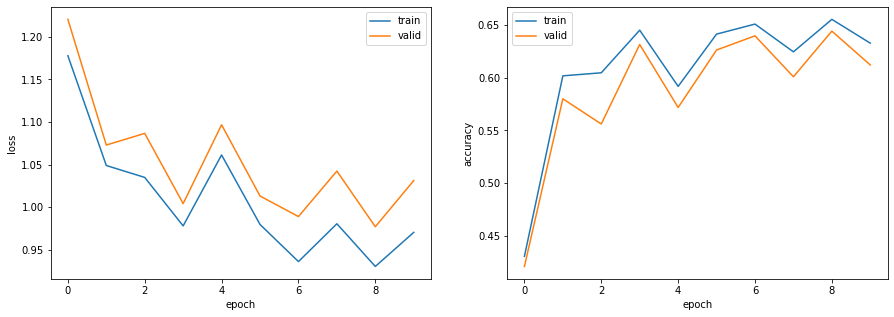

正解率（学習データ）：0.633
正解率（評価データ）：0.612


In [27]:
# ログの可視化
visualize_logs(log)

# 正解率の算出
_, acc_train = calculate_loss_and_accuracy(model, dataset_train, device)
_, acc_test = calculate_loss_and_accuracy(model, dataset_test, device)
print(f"正解率（学習データ）：{acc_train:.3f}")
print(f"正解率（評価データ）：{acc_test:.3f}")

## 86. 畳み込みニューラルネットワーク (CNN)
***
ID番号で表現された単語列$\boldsymbol x = (x_1, x_2, \dots, x_T)$がある．ただし，$T$は単語列の長さ，$x_t \in \mathbb{R}^{V}$は単語のID番号のone-hot表記である（$V$は単語の総数である）．畳み込みニューラルネットワーク（CNN: Convolutional Neural Network）を用い，単語列$\boldsymbol x$からカテゴリ$y$を予測するモデルを実装せよ．

ただし，畳み込みニューラルネットワークの構成は以下の通りとする．

+ 単語埋め込みの次元数: $d_w$
+ 畳み込みのフィルターのサイズ: 3 トークン
+ 畳み込みのストライド: 1 トークン
+ 畳み込みのパディング: あり
+ 畳み込み演算後の各時刻のベクトルの次元数: $d_h$
+ 畳み込み演算後に最大値プーリング（max pooling）を適用し，入力文を$d_h$次元の隠れベクトルで表現
 すなわち，時刻$t$の特徴ベクトル$p_t \in \mathbb{R}^{d_h}$は次式で表される．

$
p_t = g(W^{(px)} [\mathrm{emb}(x_{t-1}); \mathrm{emb}(x_t); \mathrm{emb}(x_{t+1})] + b^{(p)})
$]

ただし，$W^{(px)} \in \mathbb{R}^{d_h \times 3d_w}, b^{(p)} \in \mathbb{R}^{d_h}$はCNNのパラメータ，$g$は活性化関数（例えば$\tanh$やReLUなど），$[a; b; c]$はベクトル$a, b, c$の連結である．なお，行列$W^{(px)}$の列数が$3d_w$になるのは，3個のトークンの単語埋め込みを連結したものに対して，線形変換を行うためである．
最大値プーリングでは，特徴ベクトルの次元毎に全時刻における最大値を取り，入力文書の特徴ベクトル$c \in \mathbb{R}^{d_h}$を求める．$c[i]$でベクトル$c$の$i$番目の次元の値を表すことにすると，最大値プーリングは次式で表される．

$
c[i] = \max_{1 \leq t \leq T} p_t[i]
$

 最後に，入力文書の特徴ベクトル$c$に行列$W^{(yc)} \in \mathbb{R}^{L \times d_h}$とバイアス項$b^{(y)} \in \mathbb{R}^{L}$による線形変換とソフトマックス関数を適用し，カテゴリ$y$を予測する．

$
y = {\rm softmax}(W^{(yc)} c + b^{(y)})
$

なお，この問題ではモデルの学習を行わず，ランダムに初期化された重み行列で$y$を計算するだけでよい．

In [28]:
from torch.nn import functional as F


class CNN(nn.Module):
    def __init__(
        self,
        vocab_size,
        emb_size,
        padding_idx,
        output_size,
        out_channels,
        kernel_heights,
        stride,
        padding,
        emb_weights=None,
    ):
        super().__init__()
        if emb_weights != None:  # 指定があれば埋め込み層の重みをemb_weightsで初期化
            self.emb = nn.Embedding.from_pretrained(
                emb_weights, padding_idx=padding_idx
            )
        else:
            self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=padding_idx)
        self.conv = nn.Conv2d(
            1, out_channels, (kernel_heights, emb_size), stride, (padding, 0)
        )
        self.drop = nn.Dropout(0.3)
        self.fc = nn.Linear(out_channels, output_size)

    def forward(self, x):
        # x.size() = (batch_size, seq_len)
        emb = self.emb(x).unsqueeze(1)
        # emb.size() = (batch_size, 1, seq_len, emb_size)
        conv = self.conv(emb)
        # conv.size() = (batch_size, out_channels, seq_len, 1)
        act = F.relu(conv.squeeze(3))
        # act.size() = (batch_size, out_channels, seq_len)
        max_pool = F.max_pool1d(act, act.size()[2])
        # max_pool.size() = (batch_size, out_channels, 1) -> seq_len方向に最大値を取得
        out = self.fc(self.drop(max_pool.squeeze(2)))
        # out.size() = (batch_size, output_size)
        return out

In [29]:
# パラメータの設定
VOCAB_SIZE = len(set(word2id.values())) + 1  # 辞書のID数 + パディングID
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
OUT_CHANNELS = 100
KERNEL_HEIGHTS = 3
STRIDE = 1
PADDING = 1

# モデルの定義
model = CNN(
    VOCAB_SIZE,
    EMB_SIZE,
    PADDING_IDX,
    OUTPUT_SIZE,
    OUT_CHANNELS,
    KERNEL_HEIGHTS,
    STRIDE,
    PADDING,
    emb_weights=weights,
)

# 先頭10件の予測値取得
for i in range(10):
    X = dataset_train[i]["inputs"]
    print(torch.softmax(model(X.unsqueeze(0)), dim=-1))

tensor([[0.2361, 0.1972, 0.2853, 0.2814]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2350, 0.2305, 0.2531, 0.2814]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2092, 0.2304, 0.2705, 0.2899]], grad_fn=<SoftmaxBackward0>)
tensor([[0.1968, 0.2109, 0.2754, 0.3170]], grad_fn=<SoftmaxBackward0>)
tensor([[0.1996, 0.2127, 0.2866, 0.3011]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2103, 0.1960, 0.3004, 0.2932]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2145, 0.2387, 0.2759, 0.2709]], grad_fn=<SoftmaxBackward0>)
tensor([[0.1890, 0.2442, 0.2806, 0.2863]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2161, 0.2166, 0.2872, 0.2802]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2408, 0.2112, 0.2687, 0.2794]], grad_fn=<SoftmaxBackward0>)


## 87. 確率的勾配降下法によるCNNの学習
***
確率的勾配降下法（SGD: Stochastic Gradient Descent）を用いて，問題86で構築したモデルを学習せよ．訓練データ上の損失と正解率，評価データ上の損失と正解率を表示しながらモデルを学習し，適当な基準（例えば10エポックなど）で終了させよ．

In [30]:
# パラメータの設定
VOCAB_SIZE = len(set(word2id.values())) + 1
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
OUT_CHANNELS = 100
KERNEL_HEIGHTS = 3
STRIDE = 1
PADDING = 1
LEARNING_RATE = 5e-2
BATCH_SIZE = 64
NUM_EPOCHS = 10

# モデルの定義
model = CNN(
    VOCAB_SIZE,
    EMB_SIZE,
    PADDING_IDX,
    OUTPUT_SIZE,
    OUT_CHANNELS,
    KERNEL_HEIGHTS,
    STRIDE,
    PADDING,
    emb_weights=weights,
)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

# デバイスの指定
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# モデルの学習
log = train_model(
    dataset_train,
    dataset_valid,
    BATCH_SIZE,
    model,
    criterion,
    optimizer,
    NUM_EPOCHS,
    collate_fn=Padsequence(PADDING_IDX),
    device=device,
)

epoch: 1, loss_train: 1.0611, accuracy_train: 0.5814, loss_valid: 1.0777, accuracy_valid: 0.5689, 10.3457sec
epoch: 2, loss_train: 0.9841, accuracy_train: 0.6468, loss_valid: 1.0125, accuracy_valid: 0.6362, 9.3660sec
epoch: 3, loss_train: 0.9099, accuracy_train: 0.6966, loss_valid: 0.9492, accuracy_valid: 0.6834, 9.2855sec
epoch: 4, loss_train: 0.8466, accuracy_train: 0.7127, loss_valid: 0.8993, accuracy_valid: 0.6939, 9.5656sec
epoch: 5, loss_train: 0.8038, accuracy_train: 0.7234, loss_valid: 0.8625, accuracy_valid: 0.7021, 9.0564sec
epoch: 6, loss_train: 0.7764, accuracy_train: 0.7317, loss_valid: 0.8495, accuracy_valid: 0.7126, 9.1917sec
epoch: 7, loss_train: 0.7526, accuracy_train: 0.7391, loss_valid: 0.8306, accuracy_valid: 0.7133, 11.7414sec
epoch: 8, loss_train: 0.7403, accuracy_train: 0.7444, loss_valid: 0.8228, accuracy_valid: 0.7178, 9.2064sec
epoch: 9, loss_train: 0.7347, accuracy_train: 0.7462, loss_valid: 0.8194, accuracy_valid: 0.7178, 9.3499sec
epoch: 10, loss_train: 0.7

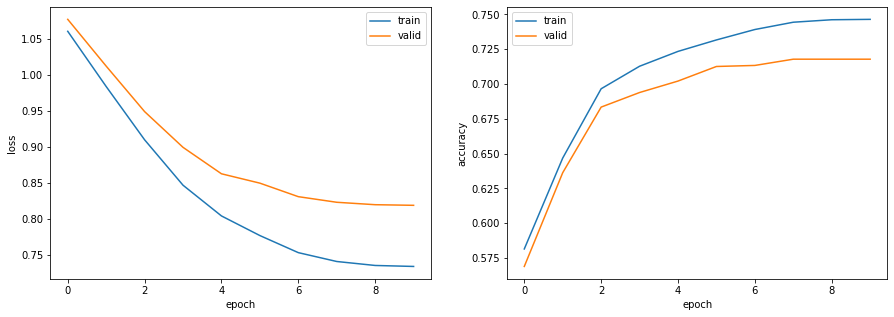

正解率（学習データ）：0.746
正解率（評価データ）：0.715


In [31]:
# ログの可視化
visualize_logs(log)

# 正解率の算出
_, acc_train = calculate_loss_and_accuracy(model, dataset_train, device)
_, acc_test = calculate_loss_and_accuracy(model, dataset_test, device)
print(f"正解率（学習データ）：{acc_train:.3f}")
print(f"正解率（評価データ）：{acc_test:.3f}")

## 88. パラメータチューニング
***
optimizerをAdamに変更

In [32]:
# パラメータの設定
VOCAB_SIZE = len(set(word2id.values())) + 1
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
OUT_CHANNELS = 100
KERNEL_HEIGHTS = 3
STRIDE = 1
PADDING = 1
LEARNING_RATE = 5e-2
BATCH_SIZE = 64
NUM_EPOCHS = 10

# モデルの定義
model = CNN(
    VOCAB_SIZE,
    EMB_SIZE,
    PADDING_IDX,
    OUTPUT_SIZE,
    OUT_CHANNELS,
    KERNEL_HEIGHTS,
    STRIDE,
    PADDING,
    emb_weights=weights,
)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# デバイスの指定
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# モデルの学習
log = train_model(
    dataset_train,
    dataset_valid,
    BATCH_SIZE,
    model,
    criterion,
    optimizer,
    NUM_EPOCHS,
    collate_fn=Padsequence(PADDING_IDX),
    device=device,
)

epoch: 1, loss_train: 1.0189, accuracy_train: 0.6866, loss_valid: 1.1617, accuracy_valid: 0.6332, 9.7320sec
epoch: 2, loss_train: 1.0384, accuracy_train: 0.7039, loss_valid: 1.0696, accuracy_valid: 0.6594, 9.5593sec
epoch: 3, loss_train: 0.8116, accuracy_train: 0.7422, loss_valid: 0.9804, accuracy_valid: 0.6954, 10.0033sec
epoch: 4, loss_train: 0.7639, accuracy_train: 0.7537, loss_valid: 0.9687, accuracy_valid: 0.6871, 9.5128sec
epoch: 5, loss_train: 0.7276, accuracy_train: 0.7721, loss_valid: 1.1680, accuracy_valid: 0.7073, 10.2789sec
epoch: 6, loss_train: 0.5546, accuracy_train: 0.8016, loss_valid: 1.0242, accuracy_valid: 0.7320, 9.4051sec
epoch: 7, loss_train: 0.5345, accuracy_train: 0.8075, loss_valid: 1.0577, accuracy_valid: 0.7126, 9.1872sec
epoch: 8, loss_train: 0.4388, accuracy_train: 0.8260, loss_valid: 0.9800, accuracy_valid: 0.7290, 9.4157sec
epoch: 9, loss_train: 0.4196, accuracy_train: 0.8303, loss_valid: 0.9690, accuracy_valid: 0.7350, 9.4350sec
epoch: 10, loss_train: 0.4

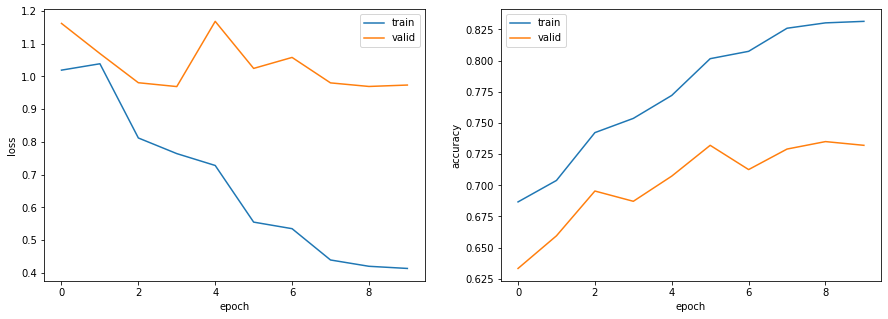

正解率（学習データ）：0.832
正解率（評価データ）：0.737


In [33]:
# ログの可視化
visualize_logs(log)

# 正解率の算出
_, acc_train = calculate_loss_and_accuracy(model, dataset_train, device)
_, acc_test = calculate_loss_and_accuracy(model, dataset_test, device)
print(f"正解率（学習データ）：{acc_train:.3f}")
print(f"正解率（評価データ）：{acc_test:.3f}")

## 89. 事前学習済み言語モデルからの転移学習
事前学習済み言語モデル（例えばBERTなど）を出発点として，ニュース記事見出しをカテゴリに分類するモデルを構築せよ．